In [1]:
import numpy as np 
from numpy import pi

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [2]:
%config InLineBackend.figure_format = 'svg'

In [3]:
def input_circuit(msg):
    msg = str(msg)[::-1]
    input_circuit = QuantumCircuit(len(msg))
    for index, value in enumerate((msg)):
        if value == '1':
            input_circuit.x(index)
    input_gate = input_circuit.to_gate()
    input_gate.name = 'Input Gate'
    return input_gate

In [32]:
def QFT_Circuit(input_gate, n):
    qft_circuit = QuantumCircuit(n)
    qft_circuit.append(input_gate, range(n))
    
    qft_circuit.barrier()
    for i in range(n):
        qft_circuit.h(n-i-1)
        j = 0
        while j < n-i-1:
            qft_circuit.cu1(pi/2**(n-i-j-1), j, n-i-1)
            j+=1
            
    qft_circuit.barrier()
    i = 0
    j = n-1
    while True:
        if i < j:
            qft_circuit.swap(i, j)
        else:
            break
        i += 1
        j -= 1
    return qft_circuit

In [35]:
inputc = input_circuit('100')

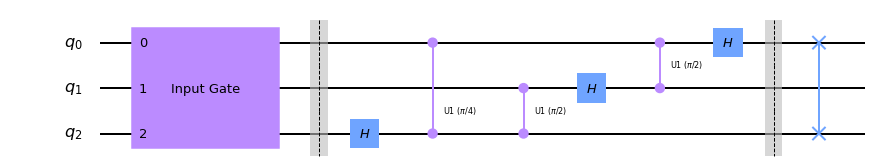

In [36]:
qft_circuit = QFT_Circuit(inputc, 3)
qft_circuit.draw(output='mpl')

In [37]:
inputc = input_circuit('1010')

In [38]:
qft_circuit = QFT_Circuit(inputc, 4)

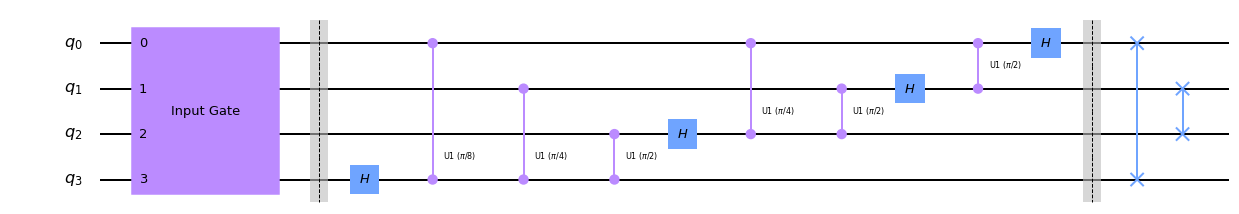

In [39]:
qft_circuit.draw(output='mpl')

In [40]:
inputc = input_circuit('101')

In [50]:
qft_circuit = QFT_Circuit(inputc, 3)

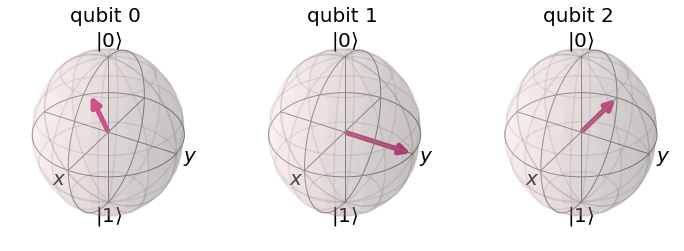

In [51]:
backend = Aer.get_backend('statevector_simulator')
count = execute(qft_circuit, backend).result().get_statevector()
plot_bloch_multivector(count)

In [122]:
def inverse_qft(n):
    inverse_qft = QFT_Circuit(QuantumCircuit(n), n).inverse()
    return inverse_qft.decompose()

In [123]:
inv_qft = inverse_qft(3)
inv_qft.draw()

┌───┐      ░ ┌──────────┐┌───────────┐                      »
q_0: ──■──┤ X ├──■───░─┤ U2(0,pi) ├┤ U1(-pi/4) ├──■────────────────■──»
       │  └─┬─┘  │   ░ └──────────┘└───────────┘┌─┴─┐┌──────────┐┌─┴─┐»
q_1: ──┼────┼────┼───░──────────────────────────┤ X ├┤ U1(pi/4) ├┤ X ├»
     ┌─┴─┐  │  ┌─┴─┐ ░                          └───┘└──────────┘└───┘»
q_2: ┤ X ├──■──┤ X ├─░────────────────────────────────────────────────»
     └───┘     └───┘ ░                                                »
«     ┌───────────┐                                                            »
«q_0: ┤ U1(-pi/8) ├────────────────────────────────────────────────────────────»
«     ├───────────┤┌──────────┐┌───────────┐                                   »
«q_1: ┤ U1(-pi/4) ├┤ U2(0,pi) ├┤ U1(-pi/4) ├──■────────────────■───────────────»
«     └───────────┘└──────────┘└───────────┘┌─┴─┐┌──────────┐┌─┴─┐┌───────────┐»
«q_2: ──────────────────────────────────────┤ X ├┤ U1(pi/4) ├┤ X ├┤ U1(-pi/4) ├»
«                                           └───┘└──────────┘└───┘└───────────┘»
«                                                     ░ ┌────────────────┐
«q_0: ──■────────────────■────────────────────────────░─┤0               ├
«       │                │                            ░ │                │
«q_1: ──┼────────────────┼────────────────────────────░─┤1 circuit129_dg ├
«     ┌─┴─┐┌──────────┐┌─┴─┐┌───────────┐┌──────────┐ ░ │                │
«q_2: ┤ X ├┤ U1(pi/8) ├┤ X ├┤ U1(-pi/8) ├┤ U2(0,pi) ├─░─┤2               ├
«     └───┘└──────────┘└───┘└───────────┘└──────────┘ ░ └────────────────┘

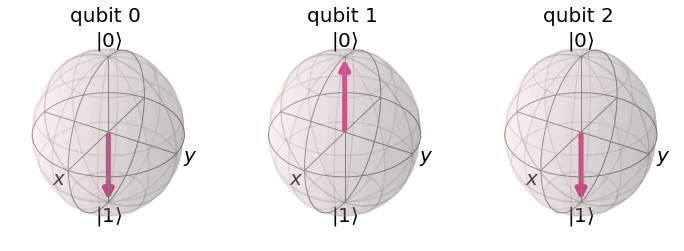

In [54]:
backend = Aer.get_backend('statevector_simulator')
count = execute(inv_qft, backend).result().get_statevector()
plot_bloch_multivector(count)

In [112]:
inputc = input_circuit('110')

In [113]:
qft_circuit = QFT_Circuit(inputc, 3)

In [116]:
inv_qft = inverse_qft(qft_circuit, 3)
inv_qft=inv_qft.decompose()

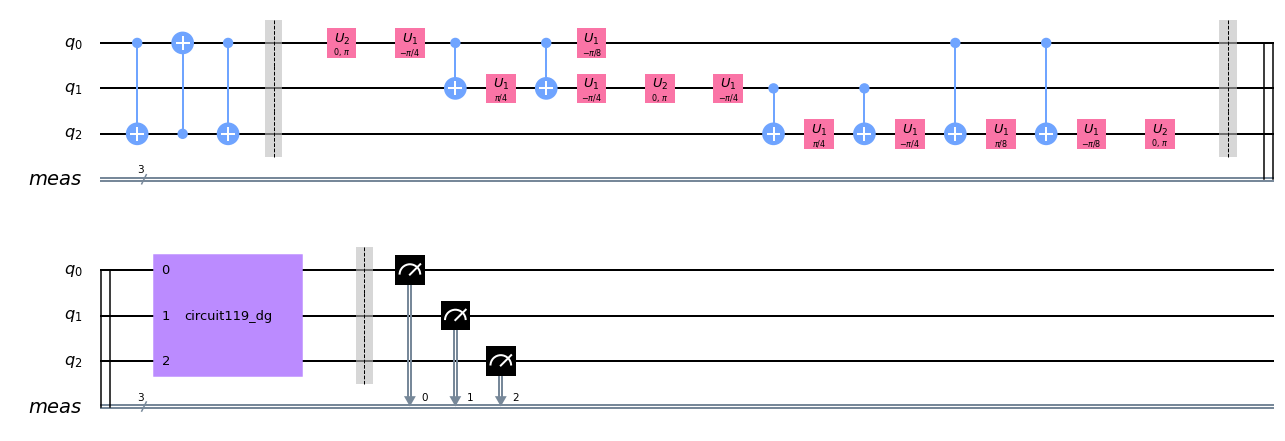

In [117]:
inv_qft.measure_all()
inv_qft.draw(output='mpl')

In [59]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [60]:
provider = IBMQ.get_provider(hub='ibm-q')

In [62]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits > 3 and
                                     not b.configuration().simulator and b.status().operational == True))

In [79]:
job_exp = execute(inv_qft, backend, shots=1024)

QiskitError: 'Cannot unroll all 3q or more gates. No rule to expand instruction circuit62_dg.'

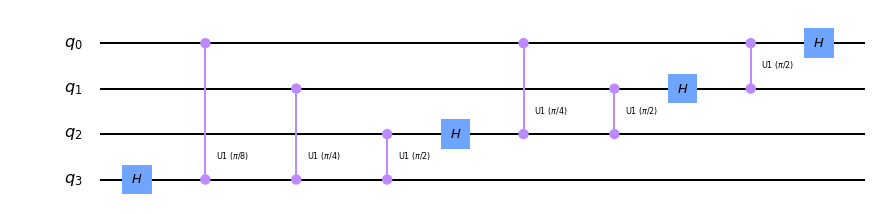

In [124]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

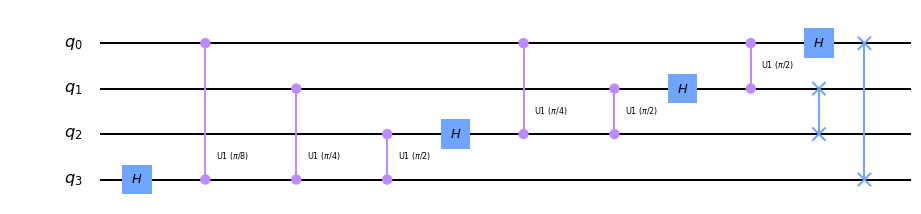

In [125]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

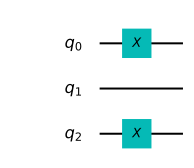

In [126]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
%config InlineBackend.figure_format = 'svg' # Makes the images fit
qc.draw('mpl')

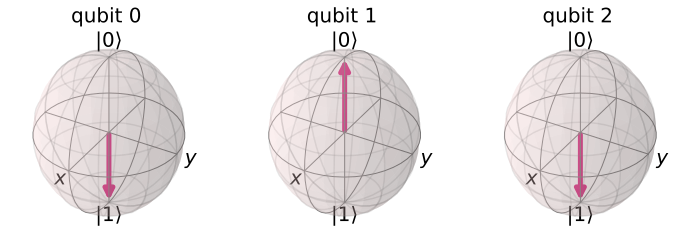

In [127]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

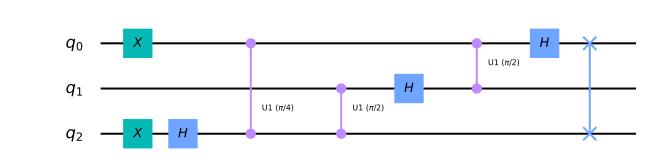

In [128]:
qft(qc,3)
qc.draw('mpl')

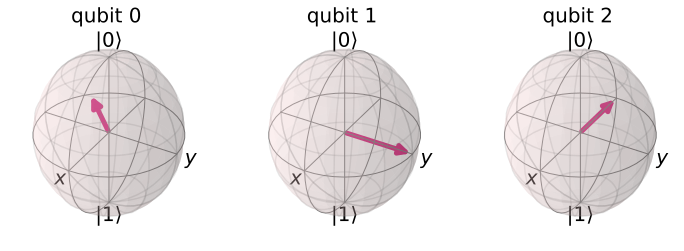

In [129]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

In [130]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

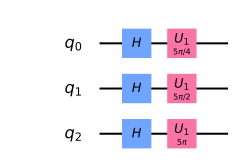

In [131]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

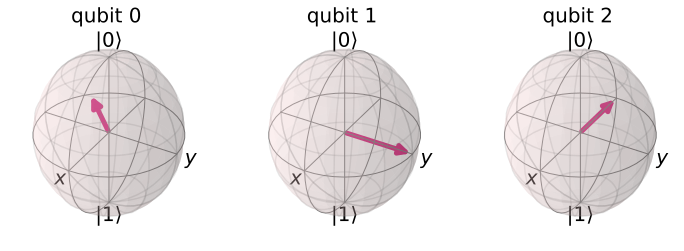

In [132]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

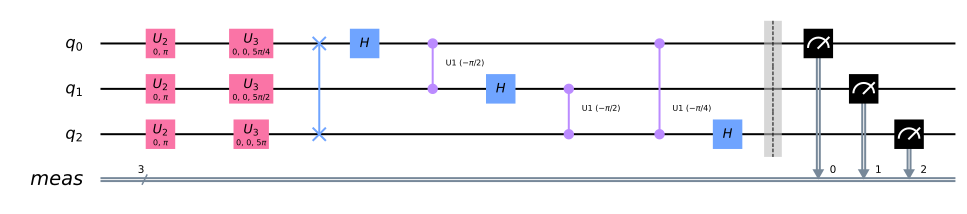

In [133]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [134]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_ourense


In [135]:
shots = 2048
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


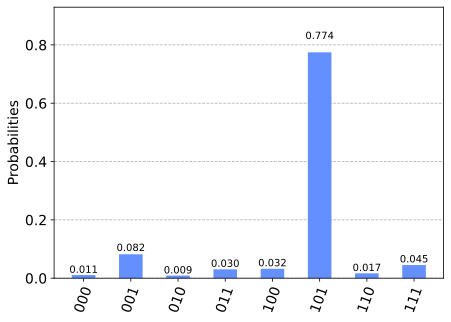

In [136]:
counts = job.result().get_counts()
plot_histogram(counts)

In [137]:
accuracy = round((counts['101'] / 2048)*100, 2)
print('The accuracy of {} for the Quantum Fourier Transform is {}%'.format(backend, accuracy))

The accuracy of ibmq_ourense for the Quantum Fourier Transform is 77.44%
